In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Adjoint methods
## Background
We will assume that we have  a set of "free" parameters that we can use for optimization, $p_\alpha$,  variables that are updated by our numerical code, $x_\beta$, and  a function the we want to optimize, $H(p_\alpha, x_\beta)$.

Since we know that the $x_\beta$'s follows the $l_\gamma$'s we can the we can add these as Lagrange multiplier without affecting the variation, meaning that 
\begin{equation*}
    \mathrm{d}L = \mathrm{d}H + \sum_\gamma\lambda_\gamma\mathrm{d}l_\gamma,
\end{equation*}
will give the same minimum as $\mathrm{d}H = 0$.

The point now is to choose the $\lambda$'s so that we remove the $\mathrm{d}x_\beta$-dependence from the variation.
\begin{align*}
    \mathrm{d}L &= \sum_\alpha\frac{\partial H}{\partial p_\alpha}\mathrm{d}p_\alpha + \sum_\beta\frac{\partial H}{\partial x_\beta}\mathrm{d}x_\beta + \sum_\gamma\lambda_\gamma\left(\sum_\alpha\frac{\partial l_\gamma}{\partial p_\alpha}\mathrm{d}p_\alpha + \sum_\beta\frac{\partial l_\gamma}{\partial x_\beta}\mathrm{d}x_\beta\right) \\
    &= \sum_\alpha\left(\frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}\right)\mathrm{d}p_\alpha + \sum_\beta\left(\frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta}\right)\mathrm{d}x_\beta.
\end{align*}
We can now choose the $\lambda$'s so that 
$$
    \frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta} = 0,
$$ 
and we are left with
\begin{equation*}
\mathrm{d}L = \sum_\alpha\left(\frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}\right)\mathrm{d}p_\alpha.
\end{equation*}
The challenge is to setup and solve the set of equations for the Lagrange multipliers.

# Diffusion
The equation we solve is the simple diffusion equation
\begin{align*}
\frac{\partial \phi}{\partial t} = \nabla\left(D\nabla\phi\right),
\end{align*}
and 
$$
\mathbf{n}\cdot\nabla\phi = 0,
$$
for the solid boundaries and
$$
 \phi(\mathbf{x}, t) = h(\mathbf{x}),
$$
for the "inlet" and "outlet" boundaries.

## Lattice Boltzmann
We will setup an LB simulation where we add a parameter to fix the flux, so that we can easily implement an immersed boundary methods for the zero flux Neumann boundary conditions. The immersed boundary method was taken from the multi-phase lattice Boltzmann solver from A. Riaud et al. [Phys. Rev. E 89, 053308 (2014)].
\begin{align*}
 g_\alpha(\mathbf{x} + \mathbf{c}_\alpha, t + 1) &= g_\alpha(\mathbf{x}, t) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}, t) - g_\alpha^\mathrm{eq}(\mathbf{x}, t)\right) + w_\alpha \beta_s(1-x)\phi\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|} \\
 &= g_\alpha(\mathbf{x}, t) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}, t) - g_\alpha^\mathrm{eq}(\mathbf{x}, t)\right) + R_\alpha(\mathbf{x})\phi
\end{align*}
where $g_\alpha^\mathrm{eq} = w_\alpha\phi$, and
$$
\lambda_s = \frac{\tau\beta_sk\xi}{D}.
$$
The $k$ is defined by the expression
$$
2k\delta_{ij} = \sum_\alpha w_\alpha\frac{c_{\alpha i}c_{\alpha j}}{|\mathbf{c}_\alpha|}.
$$
For d2q9 $k \approx 0.150$.  $\lambda_s$ seems to be treated as a "sort of" free parameter but seems to bo chosen as $\lambda_s = 1$ for examples when a diffusive field is restricted to just one region.

$\xi$ is defined by the width of the surface witch is given by
$$
x = 1/2\left(1 - \tanh(d/\xi)\right),
$$
where $d$ is the signed distance function, $d < 0$ defines the domain.

### Boundary condition (left and right hand side)
Here we use a simple bounce back to set the inlet and outlet concentrations:
$$
g_{\overline{\alpha}} + g_\alpha = 2w_\alpha\phi,
$$ 
where $\mathbf{c}_{\overline{\alpha}} = - \mathbf{c}_\alpha$.

### Boundary condition (top bottom)
Periodic



## Test of the LB scheme

Standard propagate function:

In [13]:
def circ_shift(valin, c_input):
    valout = valin
    for d, c in enumerate(c_input):
        valout = np.roll(valout, c, axis=d)
    return valout

def propagate(f, c_input):
    for q, c in enumerate(c_input):
        f[q, ...] = circ_shift(f[q, ...], c)
    return f
  

Setup the lattice:

In [14]:
c = np.array([[0, 0], [1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [-1, -1], [1, -1], [-1, 1]], dtype=int)
alpha_hat = np.array([0, 2, 1, 4, 3, 6, 5, 8, 7], dtype=int)
w = np.array([4/9] + [1/9]*4 + [1/36]*4)

#### Test case

-0.0005385981311006088 -0.00028070175438596484


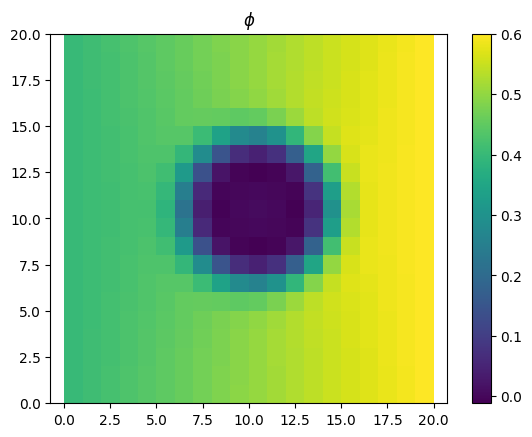

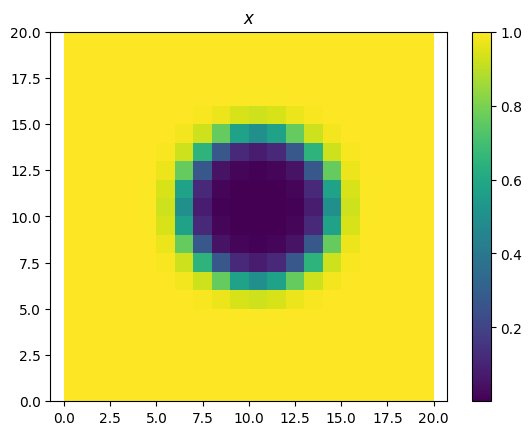

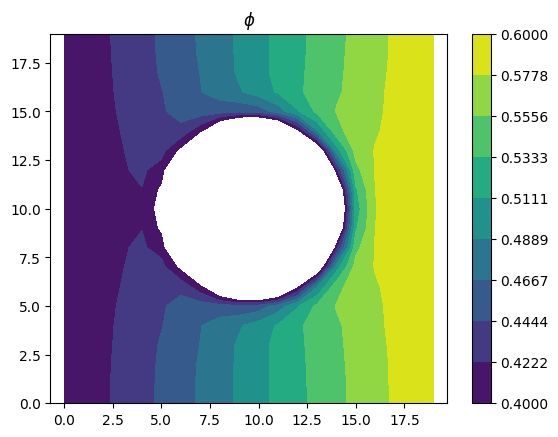

In [15]:
system_size = (20, 20)
tau = 0.7
p_jmax = 0.4

R = 4

xi = 0.8
num_iter = 10000

rho_left_hand = 0.4
rho_right_hand = 0.6

D = (tau - 0.5)/3
flux_max = -D*(rho_right_hand- rho_left_hand)/(system_size[0]-1)

# flux = np.zeros(num_iter)

def calc_source_term(R, tau, xi, w, c, system_size):
    k = 0.150
    gamma_s = 1
    D = (tau - 0.5)/3
    beta_s = gamma_s*D/(k*xi*tau)


    # set up solid geometry
    X, Y = np.mgrid[:system_size[0], :system_size[1]]
    X = X-system_size[0]/2
    Y = Y-system_size[1]/2
    d = R - np.sqrt( X**2 + Y**2 )

    x = 0.5*(1-np.tanh(d/xi))

    # normal vectors
    N = np.zeros( system_size + (2,))
    N[1:-1,1:-1,0] = -0.5*(d[2:,1:-1] - d[:-2,1:-1]) 
    N[1:-1,1:-1,1] = -0.5*(d[1:-1, 2:] - d[1:-1,:-2]) 
    N[1:-1,1:-1,:] /= np.sqrt( np.sum(N[1:-1,1:-1,:]**2, axis=-1, keepdims=True) ) + 1e-10

    # Calculate the flux source term for imposing the no-flux boundary condition
    cnorm = c / (np.sqrt( np.sum(c**2, axis=-1, keepdims= True)) + 1e-10)
    cnorm_dot_N = np.sum(cnorm.reshape(9,1,1,2)*N.reshape((1,)+N.shape), axis=-1)
    return w.reshape(9,1,1)*beta_s*(1-x).reshape((1,)+x.shape)*cnorm_dot_N, x

# Iterates the system one time step
def oneiter(g, tau, source_const, rho_left_hand, rho_right_hand, w, c):
    # Calculate the flux
    # Collision
    phi = np.sum(g, axis=0)
    g_out = (1-1/tau)*g + (1/tau)*w.reshape(9,1,1)*phi  + source_const*phi.reshape((1,)+phi.shape)

    # Propagation
    g = propagate(g_out, c)

    # Boundary conditions
    # -- left hand side
    for dir in [5, 1, 7]:
        g[dir, 0, :] = 2*w[dir]*rho_left_hand - g[alpha_hat[dir], 0, :]

    # -- Right hand side
    for dir in [8, 2, 6]:
        g[dir, -1, :] = 2*w[dir]*rho_right_hand - g[alpha_hat[dir], -1, :]
    
    return g, phi


def run_simulation(R, rho_left_hand, rho_right_hand, tau, num_iter, xi, w, c, system_size):
    source_const, x = calc_source_term(R, tau, xi, w, c, system_size)

    # Init system
    phi= 0.5*np.ones(system_size)*x
    g = w.reshape(9,1,1)*phi

    # Main loop
    for iter in np.arange(num_iter):
        g, phi = oneiter(g, tau, source_const, rho_left_hand, rho_right_hand, w, c)

    J = np.sum(g[:, 0, :]*c[:,0].reshape(9,1), axis=0)
    jx_mean = (1-0.5/tau)*np.sum(J)/system_size[1]

    return phi, jx_mean, g


source_const, x = calc_source_term(R, tau, xi, w, c, system_size)

# Init system
# phi= 0.5*np.ones(system_size)*x
# g = w.reshape(9,1,1)*phi
# g_out = np.zeros((9,)+system_size)



# # Main loop
# for iter in np.arange(num_iter):
#     # # Calculate the flux
#     # # Collision
#     # phi = np.sum(g, axis=0)
#     # g_out = (1-1/tau)*g + (1/tau)*w.reshape(9,1,1)*phi  + source_const*phi.reshape((1,)+phi.shape)

#     # # Propagation
#     # g = propagate(g_out, c)

#     # # Boundary conditions
#     # # -- left hand side
#     # for dir in [5, 1, 7]:
#     #     g[dir, 0, :] = 2*w[dir]*rho_left_hand - g[dir+1, 0, :]

#     # # -- Right hand side
#     # for dir in [8, 2, 6]:
#     #     g[dir, -1, :] = 2*w[dir]*rho_right_hand - g[dir-1, -1, :]
#     g, phi = oneiter(g, tau, source_const, rho_left_hand, rho_right_hand, w, c)

# # J = np.sum(g[:, 0, :]*c[:,0].reshape(9,1), axis=0)
# # jx_mean = (1-0.5/tau)*np.sum(J)/system_size[1]

phi, jx_mean , g = run_simulation(R, rho_left_hand, rho_right_hand, tau, num_iter, xi, w, c, system_size)

print(jx_mean, p_jmax*flux_max)

# Plots
plt.figure()
plt.title(r"$\phi$")
plt.pcolormesh(phi.transpose())
plt.axis("equal")
plt.colorbar()

plt.figure()
plt.title(r"$x$")
plt.pcolormesh(x.transpose())
plt.axis("equal")
plt.colorbar()

plt.figure()
plt.title(r"$\phi$")
plt.contourf(phi.transpose(), np.linspace(0.4, 0.6, 10))
plt.axis("equal")
plt.colorbar()


    

## Time independent LB simulations

We assume that the system is run to its stationary state, so that the lattice Boltzmann equations define a fix-point iteration scheme:
$$
g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) = g_\alpha(\mathbf{x}) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}) - g_\alpha^\mathrm{eq}(\mathbf{x})\right) + R_\alpha(\mathbf{x}),
$$
together with the boundary conditions 
$$
g_{\overline{\alpha}}(\mathbf{x}) + g_\alpha(\mathbf{x}) = 2w_\alpha x\,\phi_\mathrm{b},
$$
We can solve also solve this as a fix-point equation.


## Calculation of derivatives

Definition of the system of equations for the bulk properties:
$$
l_\alpha(\mathbf{x}) = g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) - \left(g_\alpha(\mathbf{x}) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}) - g_\alpha^\mathrm{eq}(\mathbf{x})\right) +  R_\alpha(\mathbf{x})\phi\right),
$$
The variation with respect to $g_\alpha$
\begin{align*}
\mathrm{d}_g l_\alpha(\mathbf{x}) &= \mathrm{d}g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) - \left(\left( 1 - \frac{1}{\tau}\right)\mathrm{d}g_\alpha(\mathbf{x}) + \frac{w_\alpha}{\tau}\mathrm{d}\phi + R_\alpha(\mathbf{x})\mathrm{d}\phi\right)\\
&=\mathrm{d}g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) - \left(\left( 1 - \frac{1}{\tau}\right)\mathrm{d}g_\alpha(\mathbf{x}) + \left(\frac{w_\alpha}{\tau} +  R_\alpha(\mathbf{x})\right)\mathrm{d}\phi\right),
\end{align*}
where
$$
\mathrm{d}\phi = \sum_\alpha \mathrm{d}g_\alpha(\mathbf{x})
$$

### Implementation of the bulk variance for $g_\alpha$
We can simplify the notation to
$$
\mathrm{d}g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) + a(\tau)\,\mathrm{d}g_\alpha(\mathbf{x}) + b(w_\alpha, \mathbf{c}_\alpha, \mathbf{n}, \tau, \beta_s, x)\,\mathrm{d}\phi,
$$
where
\begin{align*}
a&(\tau) = -\left( 1 - \frac{1}{\tau}\right) \\
b& (w_\alpha, \mathbf{c}_\alpha, \mathbf{n}, \tau, \beta_s, x) = -w_\alpha\left(\frac{1}{\tau} + \beta_s(1-x)\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|}\right)  = -\left(\frac{w_\alpha}{\tau} +  R_\alpha(\mathbf{x})\right)
\end{align*}

In [16]:
def sub2ind(alpha, sub, system_size):
    return 9*int(sub[0]*system_size[1] + np.mod(sub[1], system_size[1])) + alpha

gamma = 3
sub = np.array((5,7))

def dg_l_bulk(gamma, sub, tau, R_source, c,  system_size):
    c_alpha = c[gamma]
    # list of index
    sub_from = (sub - c_alpha) % system_size 
    beta = np.array([sub2ind(gamma, sub, system_size), sub2ind(gamma, sub_from, system_size)] + [sub2ind(q, sub_from, system_size) for q in np.arange(9)]) 
    a = -(1-1/tau)
    b = -(w[gamma]/tau + R_source[(gamma,) + tuple(sub_from)])
    val = np.array([1, a] + 9*[b])
    return val, beta
val_out, beta_out = dg_l_bulk(gamma, sub, tau, source_const, c, system_size)

print(beta_out)
print(val_out)




[966 957 954 955 956 957 958 959 960 961 962]
[ 1.          0.42857143 -0.15859522 -0.15859522 -0.15859522 -0.15859522
 -0.15859522 -0.15859522 -0.15859522 -0.15859522 -0.15859522]


### Implementation of the bounce back variance

For the bounce back we have that 
$$
l_\alpha(\mathrm{x}) = g_{\overline{\alpha}}(\mathbf{x}) + g_\alpha(\mathbf{x}) - 2w_\alpha x\,\phi_\mathrm{b},
$$
and 
$$
\mathrm{d}_gl_\alpha(\mathrm{x}) = \mathrm{d}g_{\overline{\alpha}}(\mathbf{x}) + \mathrm{d}g_\alpha(\mathbf{x}),
$$

In [17]:
def dg_l_bounceback(gamma, sub, alpha_hat, system_size):
    beta = np.array([sub2ind(gamma, sub, system_size), sub2ind(alpha_hat[gamma], sub, system_size)])
    val = np.array([1, 1])
    return val, beta

def dg_l_bounceback2(gamma, sub, tau, R_source, alpha_hat, system_size):
    gamma_hat = alpha_hat[gamma]
    c_alpha_hat = c[gamma_hat]
    sub_from = (sub - c_alpha_hat) % system_size 
    beta = np.array([sub2ind(gamma, sub, system_size)] + [sub2ind(gamma_hat, sub_from, system_size)] + [sub2ind(q, sub_from, system_size) for q in np.arange(9)])
    a = (1-1/tau)
    b = (w[gamma_hat]/tau + R_source[(gamma_hat,) + tuple(sub_from)])
    val = np.array([1, a] + 9*[b])

    return val, beta


val_out, beta_out = dg_l_bounceback(gamma, sub, alpha_hat, system_size)
print(beta_out)
print(val_out)

[966 967]
[1 1]


### Variation of the signed distance function

This variation is introduced through the $x$ function, so that 
$$
\mathrm{d}x = \frac{1}{2}\left(\tanh^2\left(d/\xi\right)-1\right)\mathrm{d}d = \frac{2}{\xi}(1-x)x\,\mathrm{d}d
$$

### Simple spherical boundary
$$
d = r - \sqrt{\mathbf{x}\cdot\mathbf{x}},
$$
so that 
$$
\mathrm{d}d = \mathrm{d}r
$$


For the bulk we have that
$$
\frac{\partial l_\alpha}{\partial r} = w_\alpha\beta_s\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|}\phi\frac{2}{\xi}(1-x)x\ = \frac{2x}{\xi}R_\alpha\phi
$$

In [18]:
def dr_l_bulk(gamma, sub, R_source, x, phi, xi):
    return 2*R_source[(gamma,) + tuple(sub)]*x[tuple(sub)]*phi[tuple(sub)]/xi

val_out = dr_l_bulk(gamma, sub, source_const, x, phi, xi)
print(val_out)

-0.0004889619185684137


### Cost function $H$

Here we will simply assume that we want to obtain a given \%, $p$, of the maximum flux through the system by changing the radius of the solid.
We have that the flux, $\mathbf{j}$, is given as
$$
  \mathbf{j} = \left(1-\frac{1}{2\tau}\right)\sum_\alpha g_\alpha\mathbf{c}_\alpha
$$
so that 
$$
H = \left(\left(\frac{1}{|\partial\Omega_{\mathrm{inlet}}|}\sum_{\mathbf{x}\in\partial\Omega_{\mathrm{inlet}}}j_x(\mathbf{x})\right) - pj_{\mathrm{max}}\right)^2 = \left(\langle j_x\rangle_{\partial\Omega} - pj_{\mathrm{max}}\right)^2,
$$
and
$$
\mathrm{d} H = 2\left(\langle j_x\rangle_{\partial\Omega} - pj_{\mathrm{max}}\right)\frac{\left(1-\frac{1}{2\tau}\right)}{|\partial\Omega_{\mathrm{inlet}}|}\sum_{\mathbf{x}\in\partial\Omega_{\mathrm{inlet}}}c_{\alpha x}\,\mathrm{d}g_\alpha(\mathbf{x})
$$

In [19]:
def dg_H(sub, p, jx_mean, jx_max, tau, boundary_size, c, system_size):
    tmp = 2*(jx_mean - p*jx_max)*(1-0.5/tau)/boundary_size
    val = tmp*c[1:, 0]
    ind = np.array([sub2ind(q, sub, system_size) for q in np.arange(1,9)])
    return val, ind

val_out, ind_out = dg_H(sub, 0.7, 0.5, 1.2, tau, system_size[1], c, system_size)
print(val_out)
print(ind_out)

[-0.00971429  0.00971429 -0.         -0.         -0.00971429  0.00971429
 -0.00971429  0.00971429]
[964 965 966 967 968 969 970 971]


### Calculating the Lagrange multiplier

Now we need to fill the matrixes for the calculation of the $\lambda$'s
$$
    \frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta} = 0,
$$ 
We can write this on the standard from:
$$
M_{\beta\gamma}\lambda_\gamma = y_\beta,
$$
where 
\begin{align*}
M_{\beta\gamma} &= \frac{\partial l_\gamma}{\partial x_\beta} \\
y_\beta &= -\frac{\partial H}{\partial x_\beta}.
\end{align*}

Assemble matrix =  0.775500419  s
Solving matrix system =  0.09945803  s


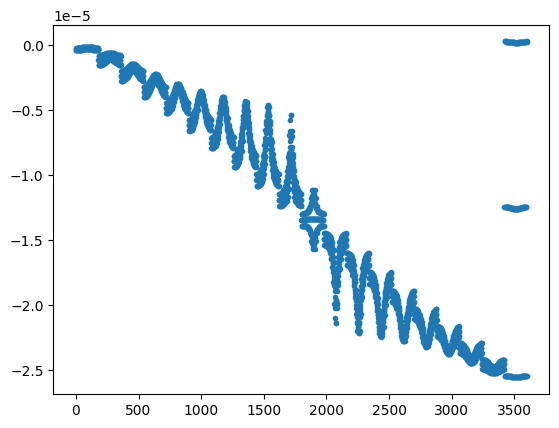

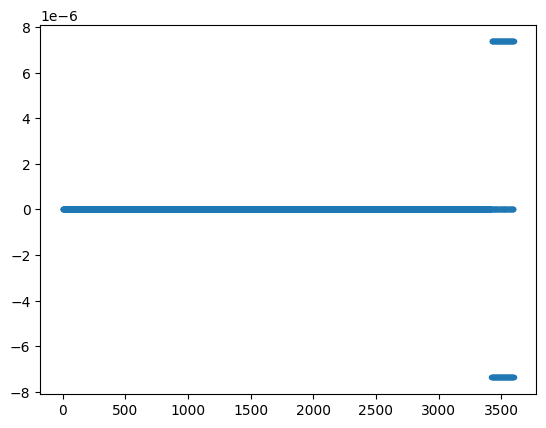

In [20]:
# Setup system of equations
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from time import time_ns

time_start = time_ns()

# Setup system size
N = 9*np.prod(system_size)

M = lil_matrix((N, N))
y = np.zeros((N,))


# Bulk part of system
for i in np.arange(1, system_size[0]-1):
    for j in np.arange(system_size[1]):
        for alpha in np.arange(9):
            gamma = sub2ind(alpha, (i, j), system_size)
            for v, beta in zip(*dg_l_bulk(alpha, (i, j), tau, source_const, c, system_size)):
                M[beta, gamma] += v

# Left hand boundary
#for i, alpha_list in zip([0, system_size[0]-1], [[1, 5, 7], [2, 6, 8]]):
i = 0
for j in np.arange(system_size[1]):
    for  alpha in np.arange(9):
        gamma = sub2ind(alpha, (i, j), system_size)
        if alpha in [1, 5, 7]:
            for v, beta in zip(*dg_l_bounceback(alpha, (i, j), alpha_hat, system_size)):
                M[beta, gamma] += v
        else:
            for v, beta in zip(*dg_l_bulk(alpha, (i, j), tau, source_const, c, system_size)):
                M[beta, gamma] += v

i = system_size[0]-1
for j in np.arange(system_size[1]):
    val, ind = dg_H((i, j), p_jmax, jx_mean, flux_max, tau, system_size[1], c, system_size)
    for v, beta in zip(val, ind):
        y[beta] -= v
    for  alpha in np.arange(9):
        gamma = sub2ind(alpha, (i, j), system_size)
        if alpha in [2, 6, 8]:
            # for v, beta in zip(*dg_l_bounceback(alpha, (i, j), alpha_hat, system_size)):
            for v, beta in zip(*dg_l_bounceback2(alpha, (i, j), tau, source_const, alpha_hat, system_size)):
                M[beta, gamma] += v
        else:
            for v, beta in zip(*dg_l_bulk(alpha, (i, j), tau, source_const, c, system_size)):
                M[beta, gamma] += v

M = M.tocsr()

print("Assemble matrix = ", (time_ns()-time_start)*1e-9, " s")

time_start = time_ns()
lag_mult = spsolve(M, y) # Lagrange multiplicator

plt.figure()
plt.plot(lag_mult, '.')

plt.figure()
plt.plot(y, '.')

print("Solving matrix system = ", (time_ns()-time_start)*1e-9, " s")


### Calculate $\partial L/\partial p_\alpha$

Here we will define this vector as
\begin{equation*}
\frac{\partial L}{\partial p_\alpha} = \frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}
\end{equation*}

1.6312078668962732e-08
-3.805914019744477e-08
-2.3331876316818247


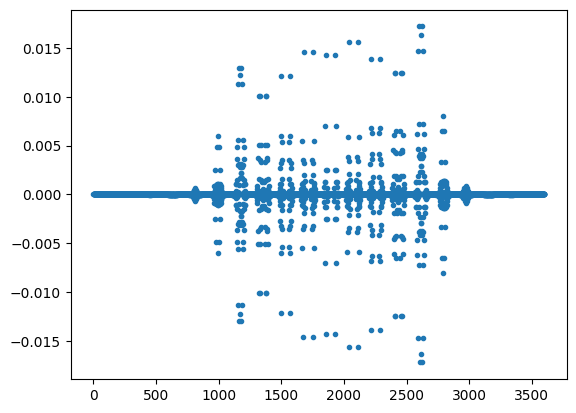

In [21]:
# Here we have  H has no functional dependency of R
dl_dR = np.zeros((N,))


# Bulk part of system
for i in np.arange(1, system_size[0]-1):
    for j in np.arange(system_size[1]):
        for alpha in np.arange(9):
            gamma = sub2ind(alpha, (i, j), system_size)
            dl_dR[gamma] += dr_l_bulk(alpha, (i,j), source_const, x, phi, xi)


# Need to include the left and right hand boundaries (use not in?)            
i = 0
for j in np.arange(system_size[1]):
    gen = (x for x in np.arange(9) if x not in [1, 5, 7])
    for alpha in gen:
        gamma = sub2ind(alpha, (i, j), system_size)
        dl_dR[gamma] += dr_l_bulk(alpha, (i,j), source_const, x, phi, xi)

i = system_size[0]-1
for j in np.arange(system_size[1]):
    gen = (x for x in np.arange(9) if x not in [2, 6, 8])
    for alpha in gen:
        gamma = sub2ind(alpha, (i, j), system_size)
        dl_dR[gamma] += dr_l_bulk(alpha, (i,j), source_const, x, phi, xi)


plt.figure()
plt.plot(dl_dR, '.')


dH_calc = np.dot(lag_mult,dl_dR) 
print(dH_calc)


H_R = (jx_mean - p_jmax*flux_max)**2
#print(H_R)
dR = 0.001

phi, jx_mean_dR, g_tmp = run_simulation(R+dR, rho_left_hand, rho_right_hand, tau, num_iter, xi, w, c, system_size)

H_RpdR = (jx_mean_dR - p_jmax*flux_max)**2
#print(H_RpdR)
dH_num = (H_RpdR - H_R)/dR
print(dH_num)
print(dH_num/dH_calc)

### Test scripts

[ 965 1145 1143 1144 1145 1146 1147 1148 1149 1150 1151]
965


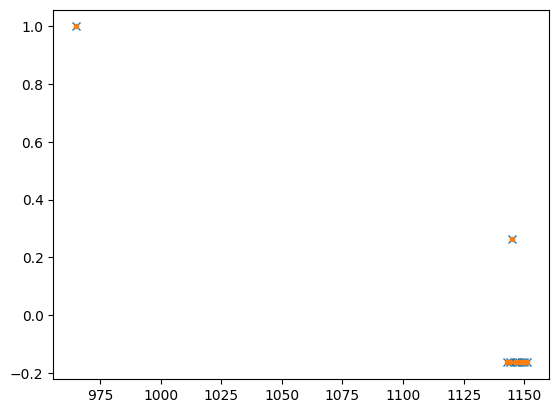

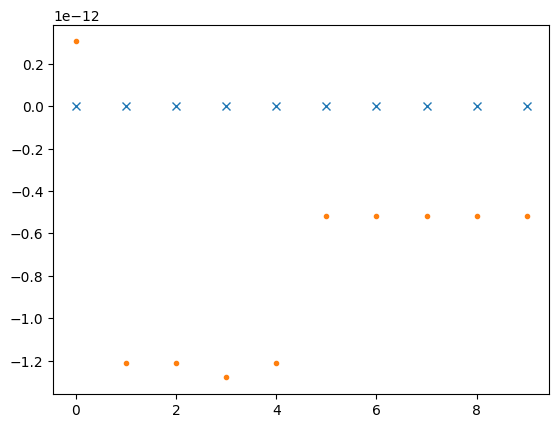

In [22]:
# Test of the bulk derivatives


param = (tau, source_const, rho_left_hand, rho_right_hand, w, c)

def l_gamma(g, tau, source_const, rho_left_hand, rho_right_hand, w, c):
    g_new, tmp = oneiter(g, tau, source_const, rho_left_hand, rho_right_hand, w, c)
    return g - g_new

g_dl = np.copy(g)

dg = 1e-5

gamma = 2
sub = np.array((5, 7))
val_calc, ind_calc = dg_l_bulk(gamma, sub, tau, source_const, c, system_size)

print(ind_calc)

sub_test = sub #+c[gamma, ...]
print(sub2ind(gamma, sub_test, system_size))
# g_dl[gamma, sub[0], sub[1]] += dg

# dl = (l_gamma(g_dl, *param) - l_gamma(g, *param))/dg
# ind = [sub2ind(a[0], a[1:], system_size) for a in np.argwhere(np.abs(dl)> 1e-10)]
# val = dl[np.abs(dl)> 1e-10]

val_num = []
ind_num = []
for i in np.arange(2, 9):
    for j in np.arange(4, 11):
        for alpha in np.arange(9):
            g_dl[alpha, i, j] += dg
            dl = (l_gamma(g_dl, *param) - l_gamma(g, *param))/dg
            g_dl[alpha, i, j] -= dg
            val =  dl[(gamma, ) + tuple(sub_test)]
            if np.abs(val) > 1e-10:
                val_num += [val]
                ind_num += [sub2ind(alpha, [i, j], system_size)]

calc = {}
for val, ind in zip(val_calc, ind_calc):
    calc[ind] = val + calc.get(ind, 0)
ind_calc = np.array(list(calc))
val_calc = np.array(list(calc.values()))

plt.figure()
plt.plot(ind_num, val_num, 'x')
plt.plot(ind_calc, val_calc, '.')

plt.figure()
ind_num = np.array(ind_num)
val_num = np.array(val_num)

for ind, val in zip([ind_num, ind_calc],[val_num, val_calc]):
    a = np.argsort(ind)
    ind[:] = ind[a]
    val[:] = val[a]

plt.plot(ind_num- ind_calc, 'x')
plt.plot(val_num - val_calc , '.')


# plt.figure()
# plt.plot(ind_num - ind_calc, 'x')
# plt.plot(val_calc - val_num, 'o')


# #tmp = np.any(np.abs(dl)> 1e-10, axis=0)
# tmp = np.sum(np.abs(dl)> 1e-10, axis=0)
# plt.figure()
# plt.pcolormesh(tmp.transpose())
# plt.axis('equal')
# plt.colorbar()



## Old text

In this setup we have that the flux, $\mathbf{j}$, is given as
$$
  \mathbf{j} = \left(1-\frac{1}{2\tau}\right)\sum_\alpha g_\alpha\mathbf{c}_\alpha + \frac{1}{2}\mathbf{q}.
$$
We want that $\mathbf{q} = 0$ except at the solid boundary where,
$$
\mathbf{n}\cdot\mathbf{q} = -2\left(1-\frac{1}{2\tau}\right)\sum_\alpha g_\alpha\mathbf{n}\cdot\mathbf{c}_\alpha,
$$
so that $\mathbf{n}\cdot\mathbf{j} = 0$.

For the inlet/outlet boundary conditions we will use a simple bounce back boundary condition. From the Chapman-Enskog procedure we get that,
$$
g_\alpha^\mathrm{neq} = \tau w_\alpha c_{\alpha, i}\left(\frac{q_i}{c_s^2}-\frac{\partial\phi}{\partial x_i}\right),
$$
that that
$$
g_\alpha + g_{\overline{\alpha}} = 2w_\alpha\phi,
$$
where $\mathbf{c}_{\overline{\alpha}} = -\mathbf{c}_\alpha$.

\begin{align*}
\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= \sum_\alpha c_{\alpha i}\tau w_\alpha c_{\alpha, j}\left(\frac{q_j}{c_s^2}-\frac{\partial\phi}{\partial x_j}\right) \\
\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= \tau c_s^2\delta_{ij}\left(\frac{q_j}{c_s^2}-\frac{\partial\phi}{\partial x_j}\right) \\
\frac{1}{\tau}\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= c_s^2\left(\frac{q_i}{c_s^2}-\frac{\partial\phi}{\partial x_i}\right) \\
\frac{1}{\tau}\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= q_i-c_s^2\frac{\partial\phi}{\partial x_i} \\
q_i - \frac{1}{\tau}\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= c_s^2\frac{\partial\phi}{\partial x_i} \\
\end{align*}